In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

batch_size = 64
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
dataloader = DataLoader(mnist, batch_size=batch_size, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.56MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.99MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_dim):
        super(ConditionalGenerator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, img_dim),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_input = self.label_embedding(labels)
        gen_input = torch.cat((noise, label_input), dim=1)
        img = self.model(gen_input)
        return img.view(img.size(0), 1, 28, 28)


In [4]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes, img_dim):
        super(ConditionalDiscriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(img_dim + num_classes, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        img_flat = img.view(img.size(0), -1)
        label_input = self.label_embedding(labels)
        d_input = torch.cat((img_flat, label_input), dim=1)
        validity = self.model(d_input)
        return validity


In [5]:
latent_dim = 100
num_classes = 10
img_dim = 28 * 28

generator = ConditionalGenerator(latent_dim, num_classes, img_dim).to("cuda")
discriminator = ConditionalDiscriminator(num_classes, img_dim).to("cuda")

adversarial_loss = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [6]:
epochs = 50
device = "cuda"

for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        batch_size = imgs.size(0)
        real_imgs = imgs.to(device)
        labels = labels.to(device)


        valid = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        z = torch.randn(batch_size, latent_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
        gen_imgs = generator(z, gen_labels)

        real_loss = adversarial_loss(discriminator(real_imgs, labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        if i % 200 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Batch {i}/{len(dataloader)} "
                  f"Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}")


Epoch [1/50] Batch 0/938 Loss D: 0.6653, Loss G: 0.6578
Epoch [1/50] Batch 200/938 Loss D: 0.6446, Loss G: 0.8417
Epoch [1/50] Batch 400/938 Loss D: 0.6445, Loss G: 0.7561
Epoch [1/50] Batch 600/938 Loss D: 0.5702, Loss G: 0.7104
Epoch [1/50] Batch 800/938 Loss D: 0.5175, Loss G: 0.9871
Epoch [2/50] Batch 0/938 Loss D: 0.4871, Loss G: 1.3945
Epoch [2/50] Batch 200/938 Loss D: 0.5355, Loss G: 0.5828
Epoch [2/50] Batch 400/938 Loss D: 0.4764, Loss G: 1.5336
Epoch [2/50] Batch 600/938 Loss D: 0.4673, Loss G: 1.2862
Epoch [2/50] Batch 800/938 Loss D: 0.4326, Loss G: 1.3822
Epoch [3/50] Batch 0/938 Loss D: 0.7163, Loss G: 0.7306
Epoch [3/50] Batch 200/938 Loss D: 0.4153, Loss G: 1.2397
Epoch [3/50] Batch 400/938 Loss D: 0.4416, Loss G: 1.6034
Epoch [3/50] Batch 600/938 Loss D: 0.5066, Loss G: 1.6184
Epoch [3/50] Batch 800/938 Loss D: 0.4701, Loss G: 0.8216
Epoch [4/50] Batch 0/938 Loss D: 0.5111, Loss G: 1.7235
Epoch [4/50] Batch 200/938 Loss D: 0.5546, Loss G: 0.6388
Epoch [4/50] Batch 400

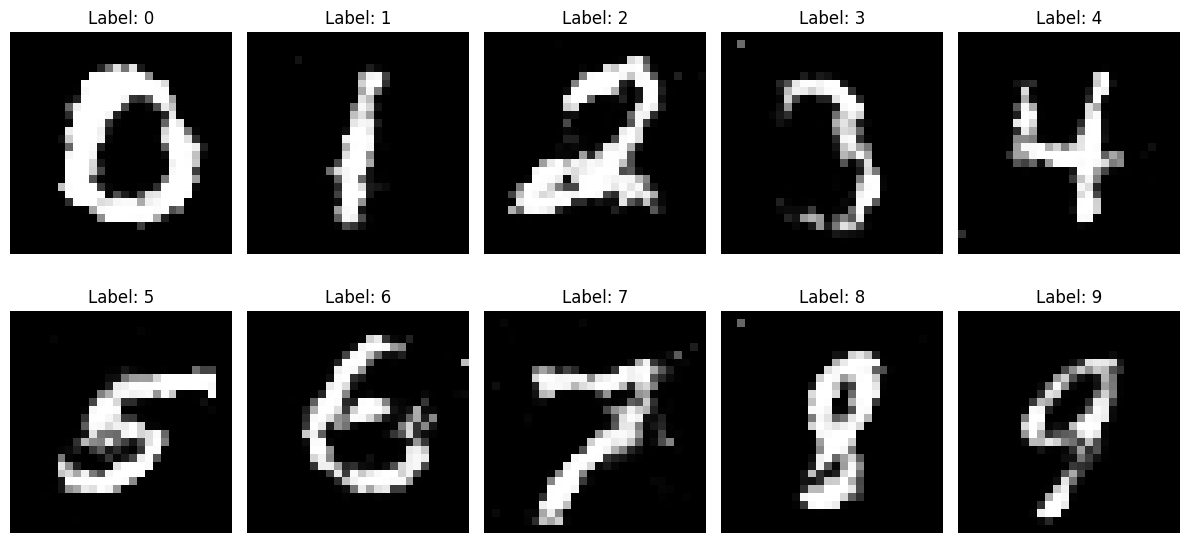

In [9]:
z = torch.randn(10, latent_dim).to(device)
labels = torch.arange(0, 10).to(device)
gen_imgs = generator(z, labels).detach().cpu()


plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(gen_imgs[i, 0], cmap="gray")
    plt.title(f"Label: {labels[i].item()}")
    plt.axis("off")
plt.tight_layout()
plt.show()
